In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import andrews_curves
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
import matplotlib.patches as mpatches
red_wine=pd.read_csv("winequality-red.csv",sep=";")
white_wine=pd.read_csv("winequality-white.csv",sep=";")

In [105]:
#Column renaming according to usual conventions
red_wine.columns=red_wine.columns.str.replace(" ","_")
white_wine.columns=white_wine.columns.str.replace(" ","_")
red_wine["type"]="red"
white_wine["type"]="white"
#Categorization of quality into three groups
red_wine["quality_label"] = red_wine["quality"].apply(lambda value: "low" if value <= 5 else "medium" if value <= 7 else "high")
white_wine["quality_label"]=white_wine["quality"].apply(lambda value: "low" if value<=5 else "medium" if value<=7 else "high")
red_wine["quality_label"]=pd.Categorical(red_wine["quality_label"],categories=["low","medium","high"])
white_wine["quality_label"]=pd.Categorical(white_wine["quality_label"],categories=["low","medium","high"])
#Combining the two wine databases
wines=pd.concat([red_wine,white_wine])
wines=wines.sample(frac=1,random_state=42).reset_index(drop=True)

In [ ]:
#FUNCTIONS
#Creates a boxplot for variables xy to z of winetype dataset. If out==False removes outliers
def boxplotter(x,y,z,winetype,out):
    fig, axes = plt.subplots(1,2, figsize=(10,10),facecolor="snow")
    temp=winetype[[z,x]]
    temp.boxplot(by=z, ax=axes[0],showfliers=out,notch=True,patch_artist=True,color="dimgray");axes[0].set_title(""); axes[0].set_xlabel(z); axes[0].set_ylabel(x)
    temp=winetype[[z,y]]
    temp.boxplot(by=z, ax=axes[1],showfliers=out,notch=True,patch_artist=True,color="dimgray");axes[1].set_title(""); axes[1].set_xlabel(z); axes[1].set_ylabel(y)

#Normalizes a dataset
def normalizer(df): 
    df=df.drop(["type","quality_label"],axis=1)
    scaler=MinMaxScaler()
    scaler.fit(df)
    scaled=scaler.fit_transform(df)
    scaled_df=pd.DataFrame(scaled,columns=df.columns)
    return scaled_df

#Takes a,b variables for x and y axis respectively. cde are the dataframes and f a boolean vlaue for normalization
def plotter(a,b,c,d,nor):
    if nor:
        c=normalizer(c)
        d=normalizer(d)
    fig, axes = plt.subplots(1,2, figsize=(14,7),facecolor="snow")
    x=sns.regplot(ax=axes[0],x=c[a],y=c[b],lowess=True,scatter_kws={"color":"crimson"},line_kws={"color":"black"})
    y=sns.regplot(ax=axes[1],x=d[a],y=d[b],lowess=True,scatter_kws={"color":"crimson"},line_kws={"color":"black"})
    return x,y

#Graphs relationship between x,y variables on df dataset
def rel_check(x,y,df):
    gg=sns.JointGrid(x=x,y=y,data=df)
    gg=gg.plot_joint(sns.regplot,color="crimson")
    gg=gg.plot_marginals(sns.histplot,kde=True,color="goldenrod")
    return gg

#Multigraphs kde,scatter and hist for all variables (It takes time)
def exp(df):
    pp = sns.PairGrid(df)
    pp = pp.map_upper(sns.kdeplot,cmap="hot",shade=True,thresh=False)
    pp = pp.map_diag(plt.hist,color="darkgrey")
    pp = pp.map_lower(sns.scatterplot,color="crimson",edgecolor="k")
    return pp

#Used for the removal of outliers
def correction(val,first,ninenine):
    if (val>=first)&(val<=ninenine):
        return val
    else:
        return np.NaN

In [ ]:
f,p=stats.f_oneway(wines[wines["quality_label"]=="low"]["alcohol"],
wines[wines["quality_label"]=="medium"]["alcohol"],
wines[wines["quality_label"]=="high"]["alcohol"])
print("ANOVA test for mean alcohol level across wine samples with different quality ratings")
print("F Statistic:",f,"\tp-value:",p)

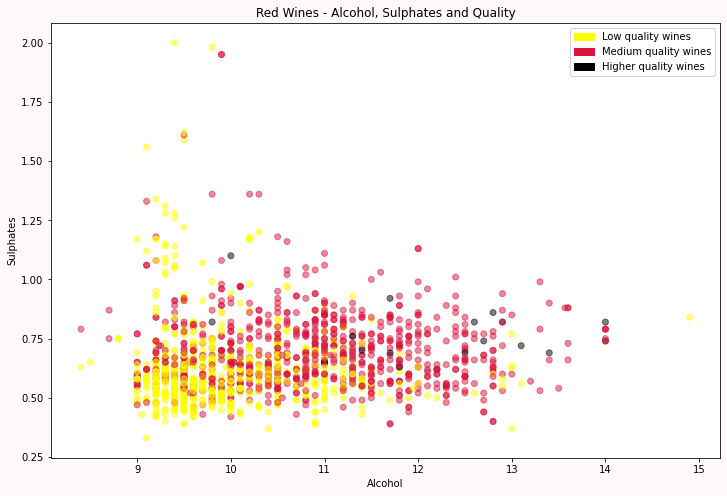

In [124]:
colors={"low":"yellow","medium":"crimson","high":"black"}
fig,axes=plt.subplots(figsize=(12,8),facecolor="snow")
scatter=axes.scatter(red_wine["alcohol"],red_wine["sulphates"],c=red_wine["quality_label"].map(colors),alpha=0.5)
axes.set_xlabel("Alcohol",fontsize=10)
axes.set_ylabel("Sulphates",fontsize=10)
axes.set_title("Red Wines - Alcohol, Sulphates and Quality")
low_quality=mpatches.Patch(color="yellow",label="Low quality wines")
medium_quality=mpatches.Patch(color="crimson",label="Medium quality wines")
high_quality=mpatches.Patch(color="black",label="Higher quality wines")
axes.legend(handles=[low_quality,medium_quality,high_quality])
plt.show()